In [2]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy import signal
from scipy.signal import argrelextrema, medfilt
import time, os
from datetime import datetime

<Axes: >

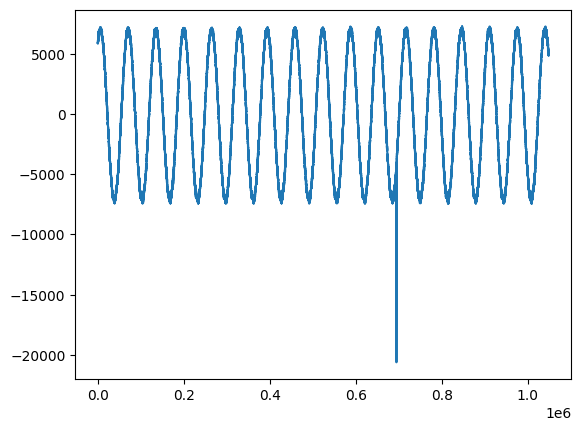

In [3]:
df_raw = pd.read_csv(os.path.join('..', 'data','data_raw.csv'), index_col=0)
%matplotlib inline
df_raw.data.plot()
# df_raw.encoder.plot()

In [4]:
# import scipy
# Применяем медианный фильтр из scipy
window_size = 3
df_filtered = pd.DataFrame(columns=['data', 'encoder'])
df_filtered.data = medfilt(df_raw.data, kernel_size=window_size)[window_size*2:-window_size*2]
df_filtered.encoder = medfilt(df_raw.encoder, kernel_size=window_size)[window_size*2:-window_size*2]

split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]
start_idx = split_points[0]
end_idx = split_points[-1]
df = df_filtered.iloc[start_idx:end_idx].copy()

# df = df_raw.copy()

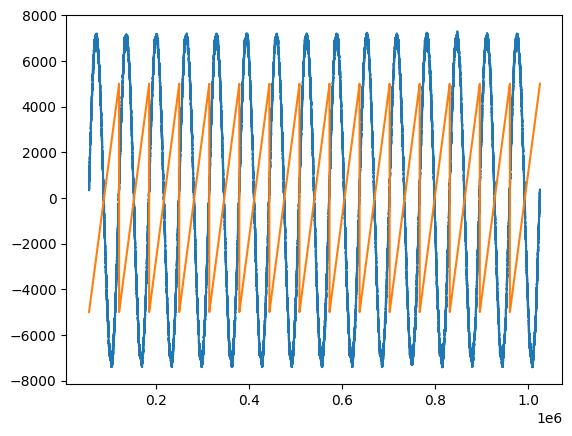

In [5]:
%matplotlib inline
# plt.plot(df_filtered.data)
plt.plot(df.data)
plt.plot((df.encoder-5000)/1)

# plt.plot(df_trimmed.encoder-5000)

In [90]:
filename = f"data_raw2_filtrimmed.csv"
predir = '..'
dir = 'data'

df.to_csv(os.path.join(predir, dir, filename))

,data,encoder,integral,volts,deg
0,2524,0,-2524.0,-1.735296e-09,0.000
1,3002,1,-5526.0,-3.799225e-09,0.036
2,2510,2,-8036.0,-5.524895e-09,0.072
3,3013,3,-11049.0,-7.596387e-09,0.108
4,3036,4,-14085.0,-9.683692e-09,0.144
...,...,...,...,...,...
149995,1968,9995,36116176.0,2.483052e-05,5399.820
149996,2007,9996,36114169.0,2.482914e-05,5399.856
149997,2442,9997,36111727.0,2.482747e-05,5399.892
149998,1828,9998,36109899.0,2.482621e-05,5399.928


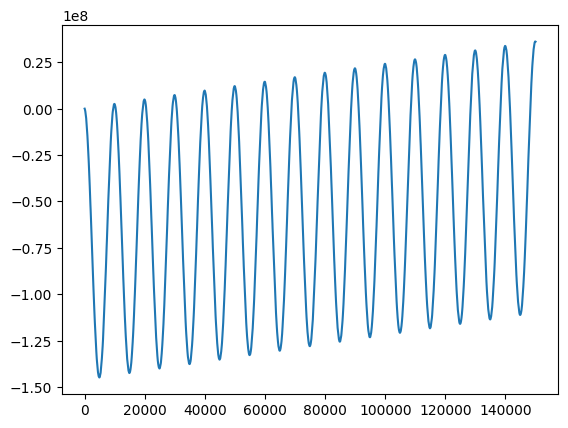

In [6]:
# Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных

# Добавим столбец, который идентифицирует периоды непрерывных значений encoder
df['period'] = (df['encoder'] != df['encoder'].shift()).cumsum()

# Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
result = df.groupby('period').agg({'data': 'sum', 'encoder': 'max'}).reset_index().drop('period', axis=1)

result['integral'] = -1.0*result.data.cumsum()

# 2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
result['volts'] = -(2.5/32767 * 1/96937 * 1/1144.8)*result.data.cumsum()

result['deg'] = result.index/10000*360

# result = result.reindex(columns=['deg', 'data'])

%matplotlib inline
# plt.plot(result.integral)
# plt.plot(result.volts)
# plt.plot((result.encoder-10000)/100000)
plt.plot(result.integral)
result


In [7]:
PT = 10000 # точек на период
N = len(result)-len(result)%PT # 150000 количество отсчетов
# omega0 = 2*np.pi/PT # угловая частота
k = int(N/PT) # номер гармоники
alpha = 2*np.cos(2*np.pi*k/N)

print(f'{N=}, {PT=}, {k=}, {alpha=:}')

N=150000, PT=10000, k=15, alpha=1.9999996052158369


In [8]:
signal = 'volts'

result['s'] = 0.0

n = 0
result.loc[n, 's'] = result.loc[n, signal] + alpha*0 - 0
n = 1
result.loc[n, 's'] = result.loc[n, signal] + alpha*result.loc[n-1, 's'] - 0

for n in range(2, len(result)):
    result.loc[n, 's'] = result.loc[n, signal] + alpha*result.loc[n-1, 's'] - result.loc[n-2, 's']

In [9]:
F2 = result.loc[N-1, 's']
F3 = result.loc[N-2, 's']

real = F2*np.cos(2*np.pi*k/N)-F3
imag = F2*np.sin(2*np.pi*k/N)

amp = np.sqrt(real**2 + imag**2)*2/N 
phi = (np.arctan2(imag, real)+np.pi/2)*180/np.pi

# amp = 1/1144.8 * amp # 2.5/32767 - Volts ; 1/96937 - sec ; 1/1144.8 - m

f'{amp = :}, {phi = :.3f}'

'amp = 5.0312589020050334e-05, phi = 94.575'

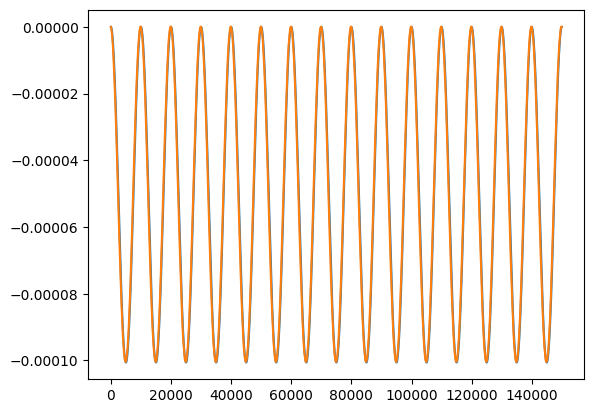

In [ ]:
# аппрокцимация синусоидой

def wave(amp, freq, phase, x):
    return amp * np.sin(2*np.pi * freq * x + phase)-amp

x =  result.index.values
y = wave(amp, 1/10000, np.pi/2, x)

# Убедимся, что индекс — это просто последовательные целые числа (0, 1, 2, ..., N-1)
x_tr = np.arange(len(result.volts))
y_tr = result.volts.values

# Координаты первой и последней точек
x0, x1 = x_tr[0], x_tr[-1]
y0, y1 = y_tr[0], y_tr[-1]

# Уравнение прямой через две точки: y_trend = a * x + b
a = (y1 - y0) / (x1 - x0) if x1 != x0 else 0
b = y0 - a * x0

# Вычисляем тренд
result['trend'] = a * x + b

# Детрендированные данные
result['detrend'] = (result.volts - result.trend)# 1144.8 - Постоянная катушки [1/м]

plt.plot(x, y)
plt.plot(x, result.detrend)

In [35]:
import fastgoertzel as fg

amp, phase = fg.goertzel(result.volts.values, 1/10000)
phase = phase*180/np.pi
print(f'Goertzel Amp: {amp:}, {phase = :}')

Goertzel Amp: 5.0312589020050334e-05, phase = 4.575044971591921


Goertzel Amp: 5.026907e-05, phase: 90.0000
FFT amp: 5.026907e-05, phase: 90.0000, freq: 1.0000e-04


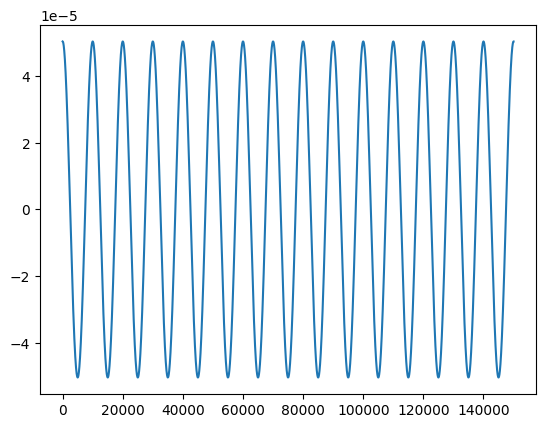

In [31]:
import numpy as np
import pandas as pd

import fastgoertzel as fg


def wave(amp, freq, phase, x):
    return amp * np.sin(2*np.pi * freq * x + phase)

N = 10000
x = np.arange(0, 150000)
y = wave(5.026907e-05, 1/N,  1*np.pi/2, x)

amp, phase = fg.goertzel(y, 1/N)
print(f'Goertzel Amp: {amp:.6e}, phase: {phase*180/np.pi+90:.4f}')

# Compared to max amplitude FFT output 
ft = np.fft.fft(y)
FFT = pd.DataFrame()
FFT['amp'] = np.sqrt(ft.real**2 + ft.imag**2) / (len(y) / 2)
FFT['freq'] = np.fft.fftfreq(ft.size, d=1)
FFT['phase'] = np.arctan2(ft.imag, ft.real)*180/np.pi+90

max_ = FFT.iloc[FFT['amp'].idxmax()]
print(f'FFT amp: {max_["amp"]:.6e}, '
        f'phase: {max_["phase"]:.4f}, '
        f'freq: {max_["freq"]:.4e}')

plt.plot(x, y)

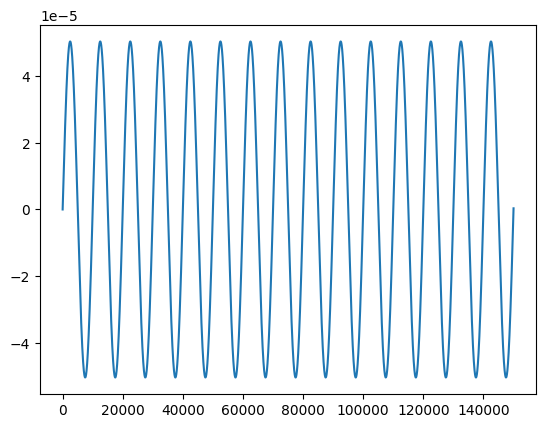

In [ ]:
import matplotlib.pyplot as plt

